In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fft-eeg/EEG_after_FFT_with_vad.csv


# Data Collection and Preparation 

In [ ]:
import scipy.io as sio
import numpy as np
import pandas as pd

matfile = sio.loadmat(r'''DREAMER.mat''')

def feature_extraction_EEG(raw):  
    EEG_b = pd.DataFrame(columns=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'])
    EEG_s = pd.DataFrame(columns=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'])
    s = [25472, 16768, 44544, 21248, 17408, 24320, 24576, 50432, 18560, 8576, 12288, 23168, 47104, 21760, 39424, 24960,
         32768, 23808]  # 18 videos

    for participant in range(0, 1):
        stimdf = pd.DataFrame(columns=['V', 'A', 'D'])
        for video in range(0, 18):
            basl = np.asarray(raw['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['baseline'][0, 0][video, 0][:, :])
            EEG_b = pd.concat((EEG_b, pd.DataFrame(basl, columns=EEG_b.columns)), ignore_index=True, axis=0)

            stim = np.asarray(raw['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0][:, :])
            stimv = matfile['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0].astype(float)
            stima = matfile['DREAMER'][0, 0]['Data'][0, participant]['ScoreArousal'][0, 0][video, 0].astype(float)
            stimd = matfile['DREAMER'][0, 0]['Data'][0, participant]['ScoreDominance'][0, 0][video, 0].astype(float)

            arrv = np.repeat([stimv], s[video], axis=0)
            arrv = np.reshape(arrv, (s[video], 1))
            arra = np.repeat([stima], s[video], axis=0)
            arra = np.reshape(arra, (s[video], 1))
            arrd = np.repeat([stimd], s[video], axis=0)
            arrd = np.reshape(arrd, (s[video], 1))

            concat_arr = np.concatenate([arrv, arra, arrd], axis=1)
            stimdf = pd.concat((stimdf, pd.DataFrame(concat_arr, columns=stimdf.columns)), axis=0)
            EEG_s = pd.concat((EEG_s, pd.DataFrame(stim, columns=EEG_s.columns)), ignore_index=True, axis=0)

    print("EEG_b and EEG_s shape ", EEG_b.shape, EEG_s.shape)  # (140544,14) (477184,14)
    return EEG_b, EEG_s, stimdf

EEG_b, EEG_s, stimdf = feature_extraction_EEG(matfile)

EEG_s_vad = EEG_s.reset_index(drop=True).merge(stimdf.reset_index(drop=True), left_index=True, right_index=True)
EEG_b.to_csv("EEG_b.csv", mode="a", index=False, header=False)
EEG_s_vad.to_csv("EEG_s_vad.csv", mode="a", index=False, header=False)
# print("EEG_s_vad head\n", EEG_s_vad.head())


# Data Preprocessing


In [ ]:
import cupy as cp
import pandas as pd
from scipy.signal import welch

# load EEG data into a pandas DataFrame
eeg_data_cpu = pd.read_csv("/kaggle/input/EEG_datasets/EEG_s_vad.csv").iloc[:,:-3]

# convert to Cupy array
eeg_data = cp.asarray(eeg_data_cpu.values)

# define frequency bands of interest
bands = {"theta": [4, 8],
         "alpha": [8, 12],
         "low_beta": [12, 16],
         "high_beta": [16, 25],
         "gamma": [25, 34]}

# set parameters for FFT calculation
window_size = 256
step_size = 16
fs = 128

# calculate FFT for each channel and frequency band
n_windows = int(cp.ceil((len(eeg_data) - window_size) / step_size))
n_channels = eeg_data.shape[1]
n_bands = len(bands)

psd_array = cp.empty((n_windows, n_channels * n_bands), dtype=cp.float32)
for i in range(n_channels):
    print("i, channel", i, eeg_data_cpu.columns[i])
    channel_data = eeg_data[:, i]
    for j, band in enumerate(bands.keys()):
        print("j, band",j, band)
        band_freqs = bands[band]
        psd = cp.zeros(n_windows, dtype=cp.float32)
        for k in range(n_windows):
            start = k * step_size
            end = start + window_size
            window = channel_data[start:end]
            freq, psd_window = welch(window.get(), fs=fs, nperseg=window_size)
            mask = (freq >= band_freqs[0]) & (freq <= band_freqs[1])
            psd[k] = cp.mean(psd_window[mask])
        psd_array[:, i*n_bands+j] = psd

# create new DataFrame with PSD data
psd_columns = [f"{channel}_{band}" for channel in eeg_data_cpu.columns for band in bands.keys()]
psd_df = pd.DataFrame(psd_array.get(), columns=psd_columns)

# print the resulting DataFrame
print(psd_df)
psd_df.to_csv("EEG_after_FFT.csv")
# 5 hrs 49 mins run time

In [ ]:
# to reduce the target variable size with a window of 16 

vad_df = eeg_vad_df.iloc[:,-3:].copy()
new_vad_df = vad_df.iloc[::16].copy()
new_vad_df_16less = new_vad_df.iloc[:-16]
new_vad_df_16less.describe()
new_vad_df_16less.tocsv('vad_16step.csv')

# Load packages and data

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('''/kaggle/input/fft-eeg/EEG_after_FFT_with_vad.csv''')

y = df.iloc[:, -2].copy()     # arousal
X = df.iloc[:, :-3].copy()

In [5]:
df.head()

,Unnamed: 0,'AF3'_theta,'AF3'_alpha,'AF3'_low_beta,'AF3'_high_beta,'AF3'_gamma,'F7'_theta,'F7'_alpha,'F7'_low_beta,'F7'_high_beta,...,'F8'_high_beta,'F8'_gamma,'AF4'_theta,'AF4'_alpha,'AF4'_low_beta,'AF4'_high_beta,'AF4'_gamma,'V','A','D'
0,0,2.692188,0.068570,0.058608,0.194440,5.309364,8.679889,0.648538,0.172991,0.522294,...,17.755291,180.26564,531.80493,38.185960,8.993058,17.429443,269.30856,4,3,2
1,1,2.849281,0.064503,0.064081,0.193473,5.421842,9.104243,0.657133,0.190933,0.537914,...,20.875635,188.35551,628.11440,33.823997,9.595490,17.155320,262.10175,4,3,2
2,2,2.763005,0.061090,0.070413,0.188286,5.547770,9.059259,0.652703,0.205034,0.552126,...,23.301527,191.18626,731.14080,27.365488,9.791175,16.433080,250.82463,4,3,2
3,3,2.462078,0.059383,0.076333,0.178514,5.649331,8.480954,0.631415,0.211561,0.565401,...,24.198807,187.30592,812.79114,20.556137,9.564130,15.443797,237.66699,4,3,2
4,4,2.053468,0.060432,0.080393,0.163780,5.709313,7.553062,0.591893,0.209167,0.574675,...,23.306349,177.03363,857.35333,14.918716,9.032654,14.861156,225.66664,4,3,2


In [6]:
X.columns = X.columns.str.replace("'","")


In [7]:
s = y.isin([5])
print(len(s))

685936


In [8]:
X = X.iloc[:, 1:]

In [9]:
X.head()

,AF3_theta,AF3_alpha,AF3_low_beta,AF3_high_beta,AF3_gamma,F7_theta,F7_alpha,F7_low_beta,F7_high_beta,F7_gamma,...,F8_theta,F8_alpha,F8_low_beta,F8_high_beta,F8_gamma,AF4_theta,AF4_alpha,AF4_low_beta,AF4_high_beta,AF4_gamma
0,2.692188,0.068570,0.058608,0.194440,5.309364,8.679889,0.648538,0.172991,0.522294,1.486322,...,379.86020,28.557722,11.705785,17.755291,180.26564,531.80493,38.185960,8.993058,17.429443,269.30856
1,2.849281,0.064503,0.064081,0.193473,5.421842,9.104243,0.657133,0.190933,0.537914,1.549444,...,429.88452,23.713800,11.257244,20.875635,188.35551,628.11440,33.823997,9.595490,17.155320,262.10175
2,2.763005,0.061090,0.070413,0.188286,5.547770,9.059259,0.652703,0.205034,0.552126,1.623562,...,491.58444,18.210754,10.246740,23.301527,191.18626,731.14080,27.365488,9.791175,16.433080,250.82463
3,2.462078,0.059383,0.076333,0.178514,5.649331,8.480954,0.631415,0.211561,0.565401,1.687086,...,541.15344,13.486537,9.243163,24.198807,187.30592,812.79114,20.556137,9.564130,15.443797,237.66699
4,2.053468,0.060432,0.080393,0.163780,5.709313,7.553062,0.591893,0.209167,0.574675,1.735789,...,567.37980,10.654698,8.678687,23.306349,177.03363,857.35333,14.918716,9.032654,14.861156,225.66664


In [10]:
y

0         3
1         3
2         3
3         3
4         3
         ..
685931    4
685932    4
685933    4
685934    4
685935    4
Name: 'A', Length: 685936, dtype: int64

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" # run with gpu 

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')


# Modeling for Arousal

In [18]:
    
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
y = y.replace(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
print("train, test split done")
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
flatten = tf.keras.layers.Flatten()(gru)
dense_1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(256, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(5, activation='softmax')(dense_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

X_train = X_train.applymap(lambda x: float(x))
X_test = X_test.applymap(lambda x: float(x))
y_train = y_train.apply(lambda x: float(x))
y_test = y_test.apply(lambda x: float(x))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
print("on-hot encoding done")

history = model.fit(
    X_train.values,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)
print("fit done")

model.save("EEG_to_Arousal.h5")

# evaluate the model
model_acc = model.evaluate(X_test, y_test, verbose=0)[1] 
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

# make predictions on the test data
y_pred = np.argmax(model.predict(X_test), axis=-1)


train, test split done
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 70)]              0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 70, 1)            0         
 a)                                                              
                                                                 
 gru_1 (GRU)                 (None, 70, 256)           198912    
                                                                 
 flatten_1 (Flatten)         (None, 17920)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               9175552   
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                    

In [19]:
y_test

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [20]:
y_pred

array([0, 1, 3, ..., 0, 3, 2])

In [21]:
y_test_values = np.argmax(y_test, axis=1)

# Model Evaluation

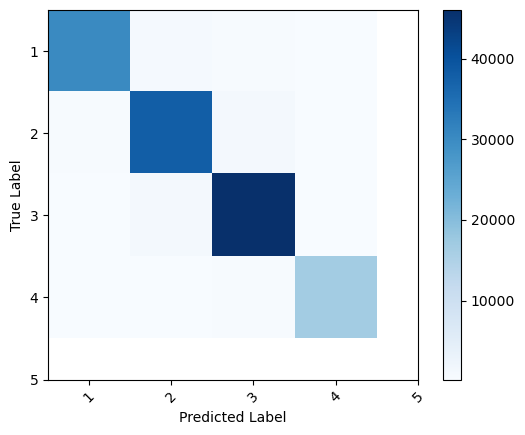

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_values, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(label_mapping))
plt.xticks(tick_marks, label_mapping.keys(), rotation=45)
plt.yticks(tick_marks, label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


As noticed from above (and can be verified using the code - s = y.isin([5])) the 'Arousal' label does not contain the class '5' in the original dataset, and thus the classification report and confusion matrix show only classes 0-3.


In [28]:
from sklearn.metrics import classification_report

# assume y_true and y_pred are arrays of true and predicted labels, respectively
report = classification_report(y_test_values, y_pred, output_dict=True)

for label in report.keys():
    if label.isdigit():
        print("Class", label)
        print("Precision:", report[label]['precision']*100,'%')
        print("Recall:", report[label]['recall']*100,'%')
        print("F1 score:", report[label]['f1-score']*100,'%')        
        print()
        
print("Overall metrics")
print("Accuracy:", report['accuracy']*100,'%')
print("Macro-averaged precision:", report['macro avg']['precision']*100,'%')
print("Macro-averaged F1 score:", report['macro avg']['f1-score']*100,'%')


Class 0
Precision: 96.28226756214788 %
Recall: 95.05687888881906 %
F1 score: 95.66564936194438 %

Class 1
Precision: 94.03814200332317 %
Recall: 95.53551182887809 %
F1 score: 94.78091334016547 %

Class 2
Precision: 95.63708889950762 %
Recall: 96.00208550573515 %
F1 score: 95.81923961574888 %

Class 3
Precision: 95.63384348830493 %
Recall: 93.42172073342736 %
F1 score: 94.5148401826484 %

Overall metrics
Accuracy: 95.31445899058227 %
Macro-averaged precision: 95.39783548832091 %
Macro-averaged F1 score: 95.19516062512679 %


# Modeling for Valence

In [33]:
y = df.iloc[:, -3].copy()     # valence
X = df.iloc[:, :-3].copy()

In [34]:
y

0         4
1         4
2         4
3         4
4         4
         ..
685931    2
685932    2
685933    2
685934    2
685935    2
Name: 'V', Length: 685936, dtype: int64

In [35]:
X.columns = X.columns.str.replace("'","")

In [36]:
X = X.iloc[:, 1:]

In [37]:
X.head()

,AF3_theta,AF3_alpha,AF3_low_beta,AF3_high_beta,AF3_gamma,F7_theta,F7_alpha,F7_low_beta,F7_high_beta,F7_gamma,...,F8_theta,F8_alpha,F8_low_beta,F8_high_beta,F8_gamma,AF4_theta,AF4_alpha,AF4_low_beta,AF4_high_beta,AF4_gamma
0,2.692188,0.068570,0.058608,0.194440,5.309364,8.679889,0.648538,0.172991,0.522294,1.486322,...,379.86020,28.557722,11.705785,17.755291,180.26564,531.80493,38.185960,8.993058,17.429443,269.30856
1,2.849281,0.064503,0.064081,0.193473,5.421842,9.104243,0.657133,0.190933,0.537914,1.549444,...,429.88452,23.713800,11.257244,20.875635,188.35551,628.11440,33.823997,9.595490,17.155320,262.10175
2,2.763005,0.061090,0.070413,0.188286,5.547770,9.059259,0.652703,0.205034,0.552126,1.623562,...,491.58444,18.210754,10.246740,23.301527,191.18626,731.14080,27.365488,9.791175,16.433080,250.82463
3,2.462078,0.059383,0.076333,0.178514,5.649331,8.480954,0.631415,0.211561,0.565401,1.687086,...,541.15344,13.486537,9.243163,24.198807,187.30592,812.79114,20.556137,9.564130,15.443797,237.66699
4,2.053468,0.060432,0.080393,0.163780,5.709313,7.553062,0.591893,0.209167,0.574675,1.735789,...,567.37980,10.654698,8.678687,23.306349,177.03363,857.35333,14.918716,9.032654,14.861156,225.66664


In [38]:
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
y = y.replace(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
print("train, test split done")
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
flatten = tf.keras.layers.Flatten()(gru)
dense_1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(256, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(5, activation='softmax')(dense_2)

model_val = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model_val.summary())

model_val.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

X_train = X_train.applymap(lambda x: float(x))
X_test = X_test.applymap(lambda x: float(x))
y_train = y_train.apply(lambda x: float(x))
y_test = y_test.apply(lambda x: float(x))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
print("on-hot encoding done")

history = model_val.fit(
    X_train.values,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)
print("fit done")

model_val.save("EEG_to_Valence.h5")

# evaluate the model
model_acc = model_val.evaluate(X_test, y_test, verbose=0)[1] 
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

# make predictions on the test data
y_pred = np.argmax(model_val.predict(X_test), axis=-1)


train, test split done
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 70)]              0         
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 70, 1)            0         
 a)                                                              
                                                                 
 gru_2 (GRU)                 (None, 70, 256)           198912    
                                                                 
 flatten_2 (Flatten)         (None, 17920)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               9175552   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                    

In [39]:
y_test

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [40]:
y_pred

array([0, 3, 2, ..., 1, 4, 0])

In [41]:
y_test_values = np.argmax(y_test, axis=1)

# Valence Model Evaluation

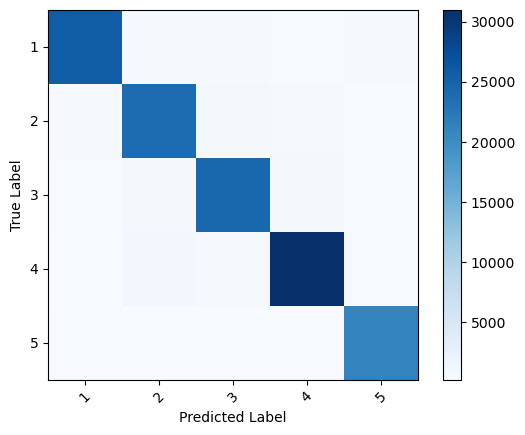

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_values, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(label_mapping))
plt.xticks(tick_marks, label_mapping.keys(), rotation=45)
plt.yticks(tick_marks, label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [43]:
from sklearn.metrics import classification_report

# assume y_true and y_pred are arrays of true and predicted labels, respectively
report = classification_report(y_test_values, y_pred, output_dict=True)

for label in report.keys():
    if label.isdigit():
        print("Class", label)
        print("Precision:", report[label]['precision']*100,'%')
        print("Recall:", report[label]['recall']*100,'%')
        print("F1 score:", report[label]['f1-score']*100,'%')        
        print()
        
print("Overall metrics")
print("Accuracy:", report['accuracy']*100,'%')
print("Macro-averaged precision:", report['macro avg']['precision']*100,'%')
print("Macro-averaged F1 score:", report['macro avg']['f1-score']*100,'%')

Class 0
Precision: 93.6020426773664 %
Recall: 92.19300136523675 %
F1 score: 92.89217904396459 %

Class 1
Precision: 89.52828415711332 %
Recall: 90.80823484559664 %
F1 score: 90.16371723289485 %

Class 2
Precision: 90.91823056300268 %
Recall: 90.38981231259024 %
F1 score: 90.65325140618909 %

Class 3
Precision: 92.48618784530387 %
Recall: 92.10933317470705 %
F1 score: 92.29737583262552 %

Class 4
Precision: 92.48696718797915 %
Recall: 93.87700653652897 %
F1 score: 93.17680289522464 %

Overall metrics
Accuracy: 91.82873137592209 %
Macro-averaged precision: 91.80434248615308 %
Macro-averaged F1 score: 91.83666528217975 %


# Modeling for Dominance

In [48]:
y = df.iloc[:, -1].copy()     # dominance
X = df.iloc[:, :-3].copy()

In [49]:
y

0         2
1         2
2         2
3         2
4         2
         ..
685931    2
685932    2
685933    2
685934    2
685935    2
Name: 'D', Length: 685936, dtype: int64

In [50]:
X.columns = X.columns.str.replace("'","")
X = X.iloc[:, 1:]

In [52]:
X.head()

,AF3_theta,AF3_alpha,AF3_low_beta,AF3_high_beta,AF3_gamma,F7_theta,F7_alpha,F7_low_beta,F7_high_beta,F7_gamma,...,F8_theta,F8_alpha,F8_low_beta,F8_high_beta,F8_gamma,AF4_theta,AF4_alpha,AF4_low_beta,AF4_high_beta,AF4_gamma
0,2.692188,0.068570,0.058608,0.194440,5.309364,8.679889,0.648538,0.172991,0.522294,1.486322,...,379.86020,28.557722,11.705785,17.755291,180.26564,531.80493,38.185960,8.993058,17.429443,269.30856
1,2.849281,0.064503,0.064081,0.193473,5.421842,9.104243,0.657133,0.190933,0.537914,1.549444,...,429.88452,23.713800,11.257244,20.875635,188.35551,628.11440,33.823997,9.595490,17.155320,262.10175
2,2.763005,0.061090,0.070413,0.188286,5.547770,9.059259,0.652703,0.205034,0.552126,1.623562,...,491.58444,18.210754,10.246740,23.301527,191.18626,731.14080,27.365488,9.791175,16.433080,250.82463
3,2.462078,0.059383,0.076333,0.178514,5.649331,8.480954,0.631415,0.211561,0.565401,1.687086,...,541.15344,13.486537,9.243163,24.198807,187.30592,812.79114,20.556137,9.564130,15.443797,237.66699
4,2.053468,0.060432,0.080393,0.163780,5.709313,7.553062,0.591893,0.209167,0.574675,1.735789,...,567.37980,10.654698,8.678687,23.306349,177.03363,857.35333,14.918716,9.032654,14.861156,225.66664


In [53]:
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
y = y.replace(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
print("train, test split done")
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
flatten = tf.keras.layers.Flatten()(gru)
dense_1 = tf.keras.layers.Dense(512, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(256, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(5, activation='softmax')(dense_2)

model_dom = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model_dom.summary())

model_dom.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

X_train = X_train.applymap(lambda x: float(x))
X_test = X_test.applymap(lambda x: float(x))
y_train = y_train.apply(lambda x: float(x))
y_test = y_test.apply(lambda x: float(x))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
print("on-hot encoding done")

history = model_dom.fit(
    X_train.values,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)
print("fit done")

model_dom.save("EEG_to_Dominance.h5")

# evaluate the model
model_acc = model_dom.evaluate(X_test, y_test, verbose=0)[1] 
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

# make predictions on the test data
y_pred = np.argmax(model_dom.predict(X_test), axis=-1)

train, test split done
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 70)]              0         
                                                                 
 tf.expand_dims_3 (TFOpLambd  (None, 70, 1)            0         
 a)                                                              
                                                                 
 gru_3 (GRU)                 (None, 70, 256)           198912    
                                                                 
 flatten_3 (Flatten)         (None, 17920)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               9175552   
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                    

In [54]:
y_test

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [55]:
y_pred

array([2, 3, 4, ..., 3, 4, 3])

In [56]:
y_test_values = np.argmax(y_test, axis=1)

In [57]:
y_test_values

array([2, 3, 4, ..., 3, 4, 3])

# Dominance Model Evaluation

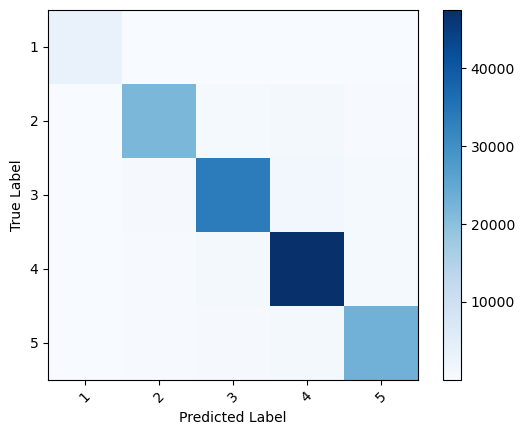

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_values, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(label_mapping))
plt.xticks(tick_marks, label_mapping.keys(), rotation=45)
plt.yticks(tick_marks, label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [59]:
from sklearn.metrics import classification_report

# assume y_true and y_pred are arrays of true and predicted labels, respectively
report = classification_report(y_test_values, y_pred, output_dict=True)

for label in report.keys():
    if label.isdigit():
        print("Class", label)
        print("Precision:", report[label]['precision']*100,'%')
        print("Recall:", report[label]['recall']*100,'%')
        print("F1 score:", report[label]['f1-score']*100,'%')        
        print()
        
print("Overall metrics")
print("Accuracy:", report['accuracy']*100,'%')
print("Macro-averaged precision:", report['macro avg']['precision']*100,'%')
print("Macro-averaged F1 score:", report['macro avg']['f1-score']*100,'%')

Class 0
Precision: 95.09359047078843 %
Recall: 92.98391569606211 %
F1 score: 94.0269209197981 %

Class 1
Precision: 95.21179438114291 %
Recall: 92.15001262732552 %
F1 score: 93.65588637919234 %

Class 2
Precision: 94.37286797665698 %
Recall: 92.94480231008441 %
F1 score: 93.65339152573193 %

Class 3
Precision: 93.69205885833762 %
Recall: 96.25516738267001 %
F1 score: 94.95632009275734 %

Class 4
Precision: 93.43238499530592 %
Recall: 93.58135731807032 %
F1 score: 93.50681182213691 %

Overall metrics
Accuracy: 94.11245881563985 %
Macro-averaged precision: 94.36053933644637 %
Macro-averaged F1 score: 93.95986614792334 %


# ****PYTORCH MLP model****


In [12]:
X = (X - X.mean()) / X.std()  # mean_normalization
label_mapping = {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4}
y = y.replace(label_mapping) 

In [14]:
import torch.nn as nn
import torch


X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.int64)

# print(y.head())
# print(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)


# print("Xt and yT", X_train.head(), X_test.head(), y_train.head(), y_test.head())


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=14, out_features=200, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(200, momentum=0.1, affine=True, track_running_stats=True),
            nn.Linear(in_features=200, out_features=100, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100, momentum=0.1, affine=True, track_running_stats=True),
            nn.Linear(in_features=100, out_features=5, bias=True),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_size = 10
for epoch in range(epoch_size):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epoch_size, loss.item()))

with torch.no_grad():
    output = model(X_test)
    predictions = torch.argmax(output, dim=1)
    accuracy = torch.sum(predictions == y_test).item() / len(y_test)
    print(f'Test accuracy: {accuracy:.2f}')

print(y_test)
print("________")
print(predictions)

savemodelpath = 'Trained_model_valence.pth'
torch.save(model.state_dict(), savemodelpath)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (548748x70 and 14x200)